In [1]:
import pandas as pd    
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
import math
import re
from tqdm.auto import tqdm
%matplotlib inline

In [2]:
path = r'C:\Users\iavoytenok\Favorites\Python\other_other\Pet_Projects\Parsing\dataframes'

In [3]:
mtgtrade_df = pd.read_csv(path +'/mtgtrade_parsing.csv')
scryfall_df = pd.read_csv(path +'/scryfall_parsing.csv')
mtg_sets_df = pd.read_excel(path +'/MTG_sets.xlsx', date_parser = pd.to_datetime)
mtg_abilities = pd.read_excel(path +'/MTG_abilities.xlsx').values.tolist()

In [4]:
scryfall_df.drop_duplicates(inplace = True)
mtgtrade_df.drop_duplicates(inplace = True)


In [5]:
mtgtrade_df['Name'] = mtgtrade_df[['Language', 'Name1', 'Name2']].apply(lambda x: x['Name1'] if x['Language'] == 'Английский' else x['Name2'], axis = 1)

In [6]:
# def isEnglish(s):
#     '''
#     Проверяем, какой из текстов на английском
#     '''
#     try:
#         s.encode(encoding='utf-8').decode('ascii')
#     except UnicodeDecodeError:
#         return False
#     else:
#         return True

In [7]:
# mtgtrade_df['English Special'] = mtgtrade_df[['Language', 'Special1', 'Special2']].apply(lambda x: x['Special1'] if isEnglish(x['Language']) else x['Special2'], axis = 1)

In [8]:
df = mtgtrade_df.merge(scryfall_df, on = 'Name')

In [9]:
df = df.merge(mtg_sets_df,left_on='Set', right_on='Name')

In [10]:
df['Feature'].fillna('', inplace = True)
df['Feature'] = df['Feature'].str.lower()

In [11]:
card_types = ['basic land', 'artifact creature', 'creature', 'instant', 'sorcery', 'enchantment creature', 'enchantment', 'land', 
             'artifact',  'planeswalker']

In [12]:
def corrected_type(main_type: str) -> str:
    '''
    Преобразует типы карт в укрупненные группы
    '''
    cor_type = 'other'
    for card_type in card_types:
        if card_type in main_type.lower():
            cor_type = card_type
            break
    return cor_type

In [13]:
df['Main type'] = df['Main type'].map(corrected_type)

In [14]:
df = df[df['Price'].isna() == False]

In [15]:
df.loc[11086]

Language                                               Английский
Set                                                      Unstable
Name1                                              Steel Squirrel
Name2                                                         NaN
Foil                                                         Фойл
Quality                                                        NM
Rarity                                                  Необычная
Price                                                325 ₽\n190 ₽
Qty                                                         1 шт.
Special1                                                      NaN
Special2        Whenever you roll a 5 or higher on a die, Stee...
Name_x                                             Steel Squirrel
Cost                                                          {2}
Type                                 Artifact Creature — Squirrel
Feature         whenever you roll a 5 or higher on a die, stee...
Stats     

In [16]:
df['Price']= df['Price'].apply(lambda x: x if x.find('\n') == -1 else x.split('\n')[1])
df['Price'] = df['Price'].str.replace(' ₽','').astype(int)
df['Qty']= df['Qty'].apply(lambda x: x if x.find('\n') == -1 else x.split('\n')[1])
df['Qty'] = df['Qty'].str.replace(' шт.','').astype(int)

C:\Users\iavoytenok\AppData\Local\Temp\ipykernel_17596\1665253984.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Qty'] = df['Qty'].str.replace(' шт.','').astype(int)


In [17]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

<AxesSubplot:xlabel='Month_sin', ylabel='Month_cos'>

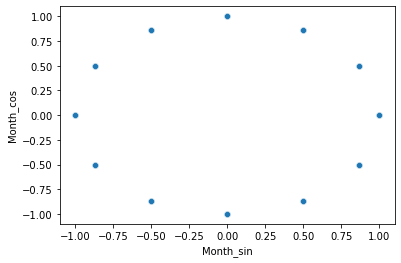

In [18]:
df["Month_cos"] = df["Month"].apply(lambda x: np.cos(x / 12 * 2 * np.pi))
df["Month_sin"] = df["Month"].apply(lambda x: np.sin(x / 12 * 2 * np.pi))
sns.scatterplot(x = df["Month_sin"], y = df["Month_cos"])

In [19]:
df['Feature length'] = df['Feature'].apply(lambda x: len(x) if type(x) != float else 0)

In [20]:
cols_to_drop = [ 'Name1', 'Name2', 'Special1', 'Special2', 'Name_y']
df.drop(cols_to_drop, inplace = True, axis = 1)

In [21]:
def get_color_cost(cost:str) -> str:
    try:
        cost = cost.replace('{', '').replace('}', '')
        color = ''.join(re.findall(r'\D+', cost))
        col_len = len(color)
        if col_len == 0:
            color = 'Colorless'
        else:
            color = ''.join([''.join(sorted(set(x))) for x in color])
        noncolor = sum([int(x) for x in re.findall(r'\d+', cost)])
        total_cost = noncolor + len(color)
    except Exception:
        color = 'Other'
        total_cost = 0
    return color, total_cost

In [22]:
def get_description_cost(feature:str) -> str:
    try:
        costs2 = feature.split('{')
        costs = [x.split('}')[0]  for x  in costs2 if len(x)> 0]
        feature_paid_abilities = len(costs)
        total_cost = 0
        color = []
        for cost in costs:
            if cost.isnumeric():
                total_cost += int(cost)
            else: 
                for c in cost:
                    if not c.isnumeric():
                        total_cost += 1
                        color.append(c)
                    else:
                        total_cost += int(c)
        color = ''.join(sorted(set(color)))
    except Exception:
        color = ''
        total_cost = 0
    return color, total_cost

In [23]:
get_description_cost('{B}: greater morphling gains your choice of banding, {C} bushido 1, {1B}double strike, fear, flying, first strike, haste, landwalk of your choice, protection from a color of your choice, provoke, rampage 1, shadow, or trample until end of turn.\n{2}: greater morphling becomes the colors of your choice until end of turn.\n{2}: greater morphling becomes the creature type of your choice until end of turn.\n{2}: greater morphling’s expansion symbol becomes the symbol of your choice until end of turn.\n{2}: greater morphling’s art becomes by the artist of your choice until end of turn.\n{2}: greater morphling gets +2/-2 or -2/+2 until end of turn.\n{2}: untap greater morphling.')

('BC', 16)

In [24]:
df['Colors_features'], df['Features cost'] = zip(*df['Feature'].map(get_description_cost))

In [25]:
df['Colors_dist'], df['Color cost'] = zip(*df['Cost'].map(get_color_cost))

In [26]:
df[['Power', 'Strength']] = df[['Power', 'Strength']].fillna(-1)

In [27]:
# df2 = df[df['Feature'].str.contains("haste")].iloc[:1000].copy()

In [28]:
def create_ability_features(abilities:List[List[str]]) -> pd.DataFrame:
    features = df['Feature'].values.tolist()
    k = []
    for ability in tqdm(abilities):
        # k = features.apply(lambda x: 1 if type(x) != float and ability in x else 0)
        k.append([1 if (type(x) != float and ability[0].lower() in x) else 0 for x in features])
    colnames = [x[1]+'_'+ x[0] for x in abilities]
    k = map(list, zip(*k))
    feat_df = pd.DataFrame(k, columns = colnames)
    return feat_df

In [29]:
df = pd.concat([df, create_ability_features(mtg_abilities)], axis = 1)

  0%|          | 0/243 [00:00<?, ?it/s]

In [30]:
df['Foil'] = df['Foil'].apply(lambda x: 1 if x == 'Фойл' else 0)

In [31]:
df = df.applymap(lambda x: 'Other' if x == '[]' else x)

In [32]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
ability_cols = df.select_dtypes(include=numerics).columns.tolist()[11:]

In [33]:
df['Total abilities qty'] = df[ability_cols].sum(axis = 1)

In [34]:
df.loc[9609]['Feature']

'{2}: greater morphling gains your choice of banding, bushido 1, double strike, fear, flying, first strike, haste, landwalk of your choice, protection from a color of your choice, provoke, rampage 1, shadow, or trample until end of turn.\n{2}: greater morphling becomes the colors of your choice until end of turn.\n{2}: greater morphling becomes the creature type of your choice until end of turn.\n{2}: greater morphling’s expansion symbol becomes the symbol of your choice until end of turn.\n{2}: greater morphling’s art becomes by the artist of your choice until end of turn.\n{2}: greater morphling gets +2/-2 or -2/+2 until end of turn.\n{2}: untap greater morphling.'

In [35]:
print(df.shape)
cols = []
for col in tqdm(ability_cols):
    if df[col].sum() < 500:
        cols.append(col)
df.drop(cols , axis = 1, inplace = True)
print(df.shape)

(580573, 285)


  0%|          | 0/244 [00:00<?, ?it/s]

(580573, 90)


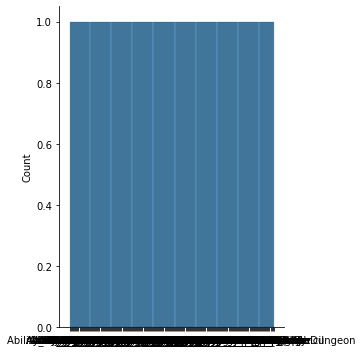

In [36]:
sns.displot(cols)

In [ ]:
df.to_csv(path + '/merged_df_new.csv', index = False)

In [36]:
df[:1].to_excel(path + '/merged_df_new.xlsx', index = False)


KeyboardInterrupt

